# Probabilistic Graphical Models for financial dependence analysis (Machine Learning)

Bortun Paolo M2QF

Fátima Lastra Incera M2QF

# PART I: BAYESIAN NETWORK MODEL

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from dataclasses import dataclass
from collections import defaultdict, deque
from sklearn.covariance import GraphicalLassoCV

## 1. Introduction

### Data

In [7]:
# LOAD DATA (market.csv, map.csv)
df = pd.read_csv("market.csv")
mp = pd.read_csv("map.csv")  
asset_to_sector = dict(zip(mp["asset"], mp["sector"]))

sector_cols = [c for c in df.columns if re.fullmatch(r"SEC\d{2}", c)]
asset_cols  = [c for c in df.columns if re.fullmatch(r"A\d{3}", c)]

# Prepare (t-1 -> t) pairs (used for DBN)
df_t   = df.iloc[1:].reset_index(drop=True)    # t
df_tm1 = df.iloc[:-1].reset_index(drop=True)   # t-1
n = len(df_t)

**Data loading and preparation**: construction of asset–sector mapping and temporal pairs for DBN estimation.

 ### Build a Dynamic BN structure (fixed)

In [10]:
# MKT_t -> SECk_t -> Ai_t  and self-lags X_{t-1} -> X_t
edges_intra_fixed = []
edges_inter_fixed = []

# Intra-temporal edges: market → sectors and sectors → assets
for s in sector_cols:
    edges_intra_fixed.append(("MKT_t", f"{s}_t"))

for a in asset_cols:
    s = asset_to_sector[a]
    edges_intra_fixed.append((f"{s}_t", f"{a}_t"))

# Inter-temporal self-lag edges
edges_inter_fixed.append(("MKT_t-1", "MKT_t"))
edges_inter_fixed += [(f"{s}_t-1", f"{s}_t") for s in sector_cols]
edges_inter_fixed += [(f"{a}_t-1", f"{a}_t") for a in asset_cols]

print("DBN structure")
print("Intra edges:", len(edges_intra_fixed))
print("Inter edges:", len(edges_inter_fixed))

DBN structure
Intra edges: 110
Inter edges: 111


This block defines the **dynamic Bayesian Network** structure by enforcing the hierarchical ordering **Market → Sector → Asset** within each time slice, and by adding self-lag edges ($t-1 \to t$) to capture possible temporal persistence in returns. This structure restricts the search space and **ensures** that the learned model remains economically interpretable.

## 2. Structure Learning

In [13]:
# STRUCTURE LEARNING (Hill Climb, BIC)

# This is used to compare different parent sets during structure search
def bic_score(y, X):
    y = np.asarray(y).reshape(-1)
    X = np.asarray(X)
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if X.size == 0:
        X = np.zeros((len(y), 0))
    X1 = np.column_stack([np.ones(len(y)), X])  
    beta, *_ = np.linalg.lstsq(X1, y, rcond=None)
    resid = y - X1 @ beta
    rss = float(resid.T @ resid)
    rss = max(rss, 1e-12)
    k = X1.shape[1]
    return len(y) * np.log(rss / len(y)) + k * np.log(len(y))

In [14]:
# This allows handling contemporaneous and lagged parents in the same way
def parent_series_all(parent):
    if parent.endswith("_t"):
        return df_t[parent[:-2]].to_numpy()
    elif parent.endswith("_t-1"):
        return df_tm1[parent[:-4]].to_numpy()
    else:
        raise ValueError(parent)

# Builds the design matrix from the selected parents
# If no parents are given, it returns an empty matrix
def build_X_all(parents):
    if not parents:
        return np.zeros((n, 0))
    return np.column_stack([parent_series_all(p) for p in parents])

In [15]:
# Hill-climbing procedure for parent selection
# Starts from an empty set and adds/removes parents as long as BIC improves
def hill_climb_parents(target_base, candidate_parents, eps=1e-6):
    y = df_t[target_base].to_numpy()
    parents = []
    best = bic_score(y, build_X_all(parents))

    improved = True
    while improved:
        improved = False

        best_add = None
        best_add_score = best
        for c in candidate_parents:
            if c in parents:
                continue
            s = bic_score(y, build_X_all(parents + [c]))
            if s < best_add_score - eps:
                best_add_score = s
                best_add = c
        if best_add is not None:
            parents.append(best_add)
            best = best_add_score
            improved = True

        best_rem = None
        best_rem_score = best
        for p in list(parents):
            trial = [x for x in parents if x != p]
            s = bic_score(y, build_X_all(trial))
            if s < best_rem_score - eps:
                best_rem_score = s
                best_rem = p
        if best_rem is not None:
            parents.remove(best_rem)
            best = best_rem_score
            improved = True

    return parents

In [16]:
edges_intra = []
edges_inter = []

# The market is only allowed to depend on its own lag
mkt_par = hill_climb_parents("MKT", ["MKT_t-1"])
if "MKT_t-1" in mkt_par:
    edges_inter.append(("MKT_t-1", "MKT_t"))
    
# Each sector can depend on the market and on its own lag
for s in sector_cols:
    cand = ["MKT_t", f"{s}_t-1"]
    pars = hill_climb_parents(s, cand)
    for p in pars:
        if p.endswith("_t"):
            edges_intra.append((p, f"{s}_t"))
        else:
            edges_inter.append((p, f"{s}_t"))

# Each asset can depend only on its sector and on its own past value
for a in asset_cols:
    sec = asset_to_sector[a]
    cand = [f"{sec}_t", f"{a}_t-1"]
    pars = hill_climb_parents(a, cand)
    for p in pars:
        if p.endswith("_t"):
            edges_intra.append((p, f"{a}_t"))
        else:
            edges_inter.append((p, f"{a}_t"))

print("\nLearned structure (Hill Climb, BIC)")
print("Learned intra edges:", len(edges_intra))
print("Learned inter edges:", len(edges_inter))


print("\n---- ASSET lag edges ----")
for e in edges_inter:
    if e[0].startswith("A"):
        print(e)

print("\n---- INTRA-TEMPORAL EDGES ---- (t -> t) ")
for e in sorted(edges_intra):
    print(e)


Learned structure (Hill Climb, BIC)
Learned intra edges: 110
Learned inter edges: 2

---- ASSET lag edges ----
('A021_t-1', 'A021_t')
('A047_t-1', 'A047_t')

---- INTRA-TEMPORAL EDGES ---- (t -> t) 
('MKT_t', 'SEC01_t')
('MKT_t', 'SEC02_t')
('MKT_t', 'SEC03_t')
('MKT_t', 'SEC04_t')
('MKT_t', 'SEC05_t')
('MKT_t', 'SEC06_t')
('MKT_t', 'SEC07_t')
('MKT_t', 'SEC08_t')
('MKT_t', 'SEC09_t')
('MKT_t', 'SEC10_t')
('SEC01_t', 'A001_t')
('SEC01_t', 'A002_t')
('SEC01_t', 'A003_t')
('SEC01_t', 'A004_t')
('SEC01_t', 'A005_t')
('SEC01_t', 'A006_t')
('SEC01_t', 'A007_t')
('SEC01_t', 'A008_t')
('SEC01_t', 'A009_t')
('SEC01_t', 'A010_t')
('SEC02_t', 'A011_t')
('SEC02_t', 'A012_t')
('SEC02_t', 'A013_t')
('SEC02_t', 'A014_t')
('SEC02_t', 'A015_t')
('SEC02_t', 'A016_t')
('SEC02_t', 'A017_t')
('SEC02_t', 'A018_t')
('SEC02_t', 'A019_t')
('SEC02_t', 'A020_t')
('SEC03_t', 'A021_t')
('SEC03_t', 'A022_t')
('SEC03_t', 'A023_t')
('SEC03_t', 'A024_t')
('SEC03_t', 'A025_t')
('SEC03_t', 'A026_t')
('SEC03_t', 'A027_

This block uses **hill climbing with BIC** to learn the structure of the network. Only reasonable parents are allowed, so the **Market → Sector → Asset** hierarchy is kept and unrealistic connections are avoided. The **result** is a simple structure that **makes sense** from a financial point of view.

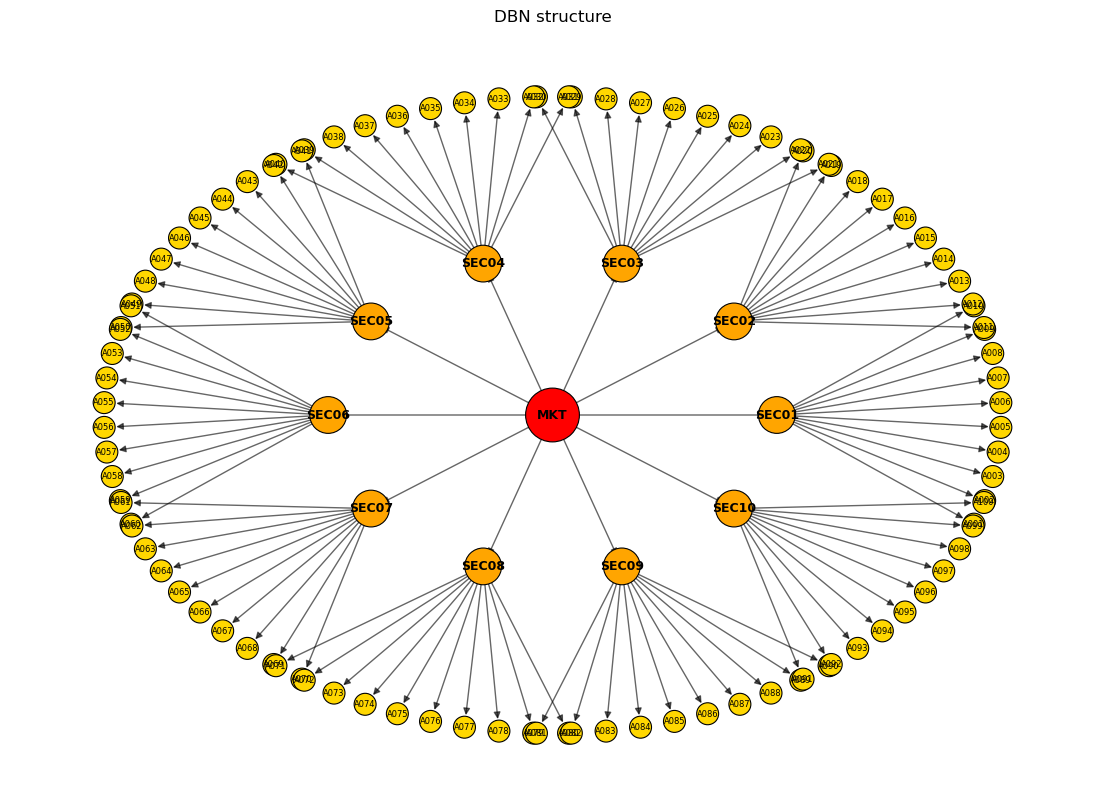

In [18]:
#Build the graph 
G = nx.DiGraph()
for u, v in edges_intra:
    G.add_edge(u, v)

#Define node sets (market, sectors, assets) 
mkt = "MKT_t"
sectors = [f"{s}_t" for s in sector_cols]     # SEC01_t, SEC02_t, ...
assets  = [f"{a}_t" for a in asset_cols]      # A001_t, A002_t, ...

#Set a simple radial layout: center -> sector ring -> asset ring
pos = {}

# Center node (market)
pos[mkt] = (0.0, 0.0)

# Sector ring
R1 = 2.0
angles_sec = np.linspace(0, 2*np.pi, len(sectors), endpoint=False)
for s, ang in zip(sectors, angles_sec):
    pos[s] = (R1*np.cos(ang), R1*np.sin(ang))

# Asset ring 
R2 = 4.0
for s in sectors:
    s_plain = s.replace("_t", "")  

    group = [f"{a}_t" for a in asset_cols if asset_to_sector[a] == s_plain]
    if not group:
        continue

    sx, sy = pos[s]
    base_ang = np.arctan2(sy, sx)

    spread = 0.35
    angles_a = np.linspace(base_ang - spread, base_ang + spread, len(group))
    for a, ang in zip(group, angles_a):
        pos[a] = (R2*np.cos(ang), R2*np.sin(ang))

# Draw everything (nodes, edges, labels) 
plt.figure(figsize=(14, 10))
plt.axis("off")
plt.title("DBN structure")

# Node style, size/color
node_colors = []
node_sizes = []
for n in G.nodes():
    if n == mkt:
        node_colors.append("red")
        node_sizes.append(1500)
    elif n.startswith("SEC"):
        node_colors.append("orange")
        node_sizes.append(700)
    else:
        node_colors.append("gold")
        node_sizes.append(250)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    linewidths=0.8
)

nx.draw_networkx_edges(
    G, pos,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=10,
    width=1.0,
    alpha=0.6
)

# Labels
labels_main = {mkt: "MKT"}
labels_main.update({s: s.replace("_t", "") for s in sectors})
nx.draw_networkx_labels(G, pos, labels=labels_main, font_size=9, font_weight="bold")

labels_assets = {a: a.replace("_t", "") for a in assets}
nx.draw_networkx_labels(G, pos, labels=labels_assets, font_size=6)

plt.show()

## 3. Parameter Learning

### Fit conditional distributions given the learned structure (LINEAR GAUSSIAN CPDs)

In [21]:
# Given the learned graph, we fit one linear regression per node
# child_t = intercept + sum(parent effects) + Gaussian noise

# Get the data for a variable at time t or t-1, depending on its name
def series_from_name(var_name, df_t, df_tm1):
    if var_name.endswith("_t"):
        base = var_name[:-2]
        return df_t[base].to_numpy()
    elif var_name.endswith("_t-1"):
        base = var_name[:-4]
        return df_tm1[base].to_numpy()
    else:
        raise ValueError(f"Bad var name: {var_name}")

# Fit linear Gaussian CPDs for all nodes, given the learned BN structure
def fit_linear_gaussian_cpds(
    edges_intra,
    edges_inter,
    df_t,
    df_tm1,
    sector_cols,
    asset_cols
):
   
    n = len(df_t)
    if len(df_tm1) != n:
        raise ValueError("df_t and df_tm1 must have same length")
    
    # List all nodes at time t (market + sectors + assets)
    nodes_t = (
        ["MKT_t"] +
        [f"{s}_t" for s in sector_cols] +
        [f"{a}_t" for a in asset_cols]
    )
    
    # Build parent lists from the learned edges (both intra and lagged)
    parents = {node: [] for node in nodes_t}

    for p, c in edges_intra:
        if c in parents:
            parents[c].append(p)

    for p, c in edges_inter:
        if c in parents:
            parents[c].append(p)

    # Fit one OLS regression per node (this is the linear-Gaussian CPD)
    cpds = {}

    for child in nodes_t:
        pa_list = parents[child]

        y = series_from_name(child, df_t, df_tm1).reshape(-1, 1)

        if pa_list:
            X = np.hstack(
                [series_from_name(p, df_t, df_tm1).reshape(-1, 1) for p in pa_list]
            )
        else:
            X = np.zeros((n, 0))

        # Add intercept and estimate coefficients with least squares
        X1 = np.hstack([np.ones((n, 1)), X])
        beta, *_ = np.linalg.lstsq(X1, y, rcond=None)
        
        # Estimate noise variance (sigma^2) from residuals
        resid = y - X1 @ beta
        rss = float((resid.T @ resid).item())
        k = X1.shape[1]                 # number of parameters
        dof = max(n - k, 1)             # avoid division by zero
        sigma2 = rss / dof

        cpds[child] = {
            "parents": pa_list,
            "beta": beta.flatten(),     
            "sigma2": float(sigma2),
            "dof": int(dof)
        }

    return cpds
    
# Run the CPD fitting and print a quick sanity check on a few nodes
cpds = fit_linear_gaussian_cpds(
    edges_intra,
    edges_inter,
    df_t,
    df_tm1,
    sector_cols,
    asset_cols
)
print("Total number of estimated CPDs:", len(cpds))

for node in ["MKT_t", f"{sector_cols[0]}_t", f"{asset_cols[0]}_t"]:
    print("\nNODE:", node)
    print("parents:", cpds[node]["parents"])
    print("beta:", cpds[node]["beta"])
    print("sigma2:", cpds[node]["sigma2"])

Total number of estimated CPDs: 111

NODE: MKT_t
parents: []
beta: [-0.00037939]
sigma2: 9.524717684673993e-05

NODE: SEC01_t
parents: ['MKT_t']
beta: [2.66411610e-04 1.08485882e+00]
sigma2: 6.955568176369126e-05

NODE: A001_t
parents: ['SEC01_t']
beta: [3.09792105e-04 8.34310384e-01]
sigma2: 4.774943808265073e-05


Given the learned structure, we **estimate linear Gaussian CPDs** by fitting one linear regression per node on its parents, obtaining regression coefficients and residual variance σ².

### Time-based split (70% train + 30% test)

In [24]:
n = len(df)
cut = int(0.70 * n)
train_df = df.iloc[:cut].reset_index(drop=True)
test_df  = df.iloc[cut:].reset_index(drop=True)

print("Total rows:", n)
print("Train rows:", len(train_df))
print("Test rows:", len(test_df))

Total rows: 1000
Train rows: 700
Test rows: 300


### Predictions for the first 5 assets

In [26]:
# OLS function used for training and prediction
def ols_fit_predict(y_train, X_train, X_test):
    X1_train = np.column_stack([np.ones(len(y_train)), X_train])
    beta, *_ = np.linalg.lstsq(X1_train, y_train, rcond=None)

    X1_test = np.column_stack([np.ones(len(X_test)), X_test])
    y_pred = X1_test @ beta
    return beta, y_pred

# Select the first five assets
assets_5 = asset_cols[:5]

# Loop over selected assets and follow the Market → Sector → Asset structure
for a in assets_5:
    sec = asset_to_sector[a]   

    # Predict sector return from market return (M → S)
    yS_train = train_df[sec].to_numpy()
    XS_train = train_df[["MKT"]].to_numpy()

    XS_test  = test_df[["MKT"]].to_numpy()
    beta_S, S_pred_test = ols_fit_predict(yS_train, XS_train, XS_test)

    # Predict asset return using the predicted sector (S → A)
    yA_train = train_df[a].to_numpy()
    XA_train = train_df[[sec]].to_numpy()  

    XA_test  = S_pred_test.reshape(-1, 1)  
    beta_A, A_pred_test = ols_fit_predict(yA_train, XA_train, XA_test)

    # Compare true vs predicted asset returns on the test set and compute MSE
    out = pd.DataFrame({
        "y_true": test_df[a].to_numpy(),
        "y_pred": A_pred_test
    })

    mse = float(np.mean((out["y_true"] - out["y_pred"])**2))

    print(f"\nAsset {a} via M→S→A (test first 10)")
    print("Sector model:", f"{sec} = b0 + b1*MKT ; b1={beta_S[1]:.3f}")
    print("Asset model :", f"{a} = c0 + c1*{sec} ; c1={beta_A[1]:.3f}")
    print(out.head(10))
    print("MSE:", mse)


Asset A001 via M→S→A (test first 10)
Sector model: SEC01 = b0 + b1*MKT ; b1=1.069
Asset model : A001 = c0 + c1*SEC01 ; c1=0.832
     y_true    y_pred
0  0.009718  0.011799
1  0.013220  0.010152
2  0.009311 -0.000758
3 -0.020615 -0.012228
4  0.001067 -0.011433
5  0.003626  0.001702
6  0.017471  0.005069
7 -0.040532 -0.018186
8 -0.005576 -0.002672
9  0.019890  0.014573
MSE: 0.0001096263136256755

Asset A002 via M→S→A (test first 10)
Sector model: SEC01 = b0 + b1*MKT ; b1=1.069
Asset model : A002 = c0 + c1*SEC01 ; c1=0.564
     y_true    y_pred
0  0.014761  0.007744
1 -0.004305  0.006628
2  0.008785 -0.000767
3  0.004303 -0.008542
4 -0.035971 -0.008003
5  0.020085  0.000900
6 -0.001173  0.003182
7 -0.029137 -0.012580
8  0.023118 -0.002065
9  0.030802  0.009625
MSE: 0.00024283867197275142

Asset A003 via M→S→A (test first 10)
Sector model: SEC01 = b0 + b1*MKT ; b1=1.069
Asset model : A003 = c0 + c1*SEC01 ; c1=1.089
     y_true    y_pred
0  0.011906  0.015571
1 -0.001021  0.013416
2 -0.003

We generate out-of-sample **predictions** for a few assets using a time-based split, following the learned Market → Sector → Asset structure and **evaluating performance with mean squared error.**

### Prediction Plot

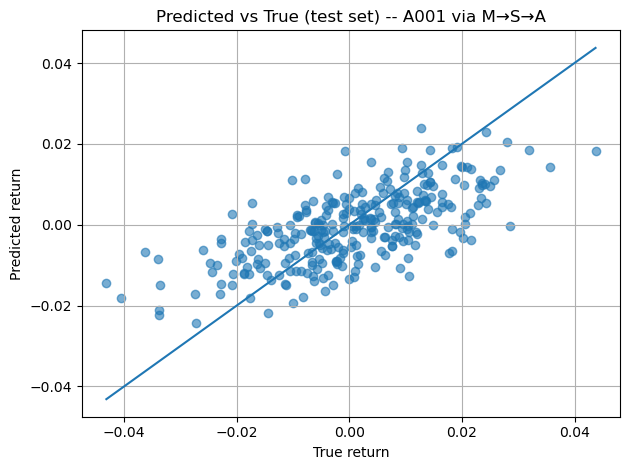

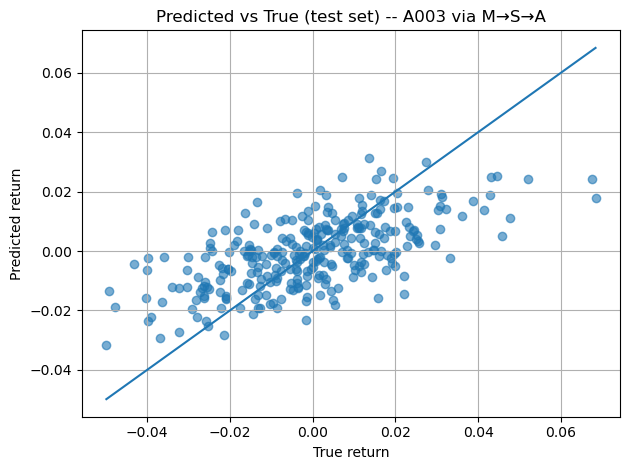

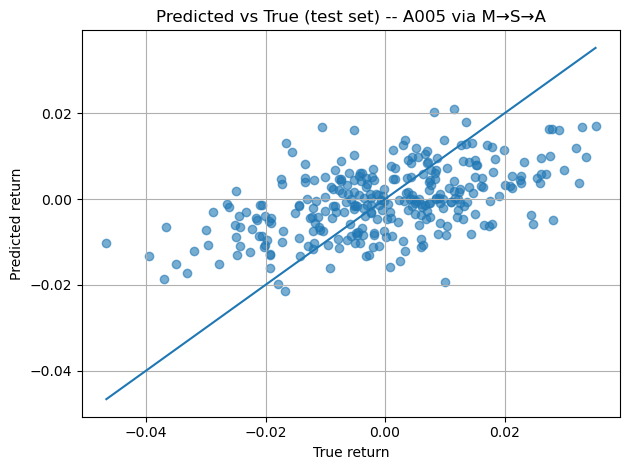

In [29]:
# Select assets 1,3,5
assets_plot = [asset_cols[i] for i in [0, 2, 4]]

# Loop over selected assets and compute predictions following M → S → A
for a in assets_plot:
    sec = asset_to_sector[a]

    # Predict sector return from market return (M → S)
    yS_train = train_df[sec].to_numpy()
    XS_train = train_df[["MKT"]].to_numpy()
    XS_test  = test_df[["MKT"]].to_numpy()
    beta_S, S_pred_test = ols_fit_predict(yS_train, XS_train, XS_test)

    # Predict asset return using the predicted sector (S → A))
    yA_train = train_df[a].to_numpy()
    XA_train = train_df[[sec]].to_numpy()
    XA_test  = S_pred_test.reshape(-1, 1)
    beta_A, A_pred_test = ols_fit_predict(yA_train, XA_train, XA_test)

    y_true = test_df[a].to_numpy()
    y_pred = A_pred_test

    # Plot predicted vs true returns on the test set
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.6)
    lim = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
    plt.plot(lim, lim)
    plt.xlabel("True return")
    plt.ylabel("Predicted return")
    plt.title(f"Predicted vs True (test set) -- {a} via M→S→A")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

This block visualizes the **prediction performance** for a few assets by comparing true and predicted returns on the test set.

# PART II: MARKOV NETWORK FIELD

In [32]:
import numpy as np
import pandas as pd

from dataclasses import dataclass
from collections import defaultdict, deque

from sklearn.preprocessing import StandardScaler
from sklearn.covariance import graphical_lasso
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from numpy.linalg import slogdet
from joblib import Parallel, delayed

## 1. Introduction

### Data 

In [35]:
# LOAD DATA (market.csv, map.csv)
map_df = pd.read_csv(
    "map.csv",           
    names=["Asset", "Sector"],
    sep=","
)
asset_to_sector = dict(zip(map_df["Asset"], map_df["Sector"]))

df = pd.read_csv("market.csv", sep=",")  

print(map_df.tail())
print() 
print(df.head(2))

    Asset Sector
96   A096  SEC10
97   A097  SEC10
98   A098  SEC10
99   A099  SEC10
100  A100  SEC10

        MKT     SEC01     SEC02     SEC03     SEC04     SEC05     SEC06  \
0  0.014778  0.013723  0.006033  0.012443 -0.006072  0.015750  0.020189   
1  0.004882  0.015384 -0.001119 -0.003761 -0.000143  0.004392  0.009303   

      SEC07     SEC08     SEC09  ...      A091      A092      A093      A094  \
0  0.025308  0.016131  0.006779  ...  0.019686 -0.003754  0.008045  0.039881   
1  0.006761  0.007748  0.007224  ...  0.036371  0.003600  0.028597  0.024576   

       A095      A096      A097      A098      A099      A100  
0  0.019591  0.002210  0.002275  0.004863 -0.006108 -0.005238  
1  0.012501  0.015962  0.043648  0.019679  0.028817  0.023622  

[2 rows x 111 columns]


### Time-based split (70% train + 30% test)

In [37]:
# Split the time series into training and test sets and standardize asset returns using training statistics only
def standardize_train_test(X: np.ndarray, train_ratio: float):
    T = X.shape[0]
    split = int(train_ratio * T)

    X_train_raw = X[:split]
    X_test_raw  = X[split:]

    mu = X_train_raw.mean(axis=0)
    sd = X_train_raw.std(axis=0, ddof=0)
    sd = np.where(sd == 0, 1.0, sd)

    X_train = (X_train_raw - mu) / sd
    X_test  = (X_test_raw  - mu) / sd
    
    return X_train, X_test, mu, sd

# Select only the columns of assets (A001, A002, ...)
asset_cols = [c for c in df.columns if c.startswith("A")]
X = df[asset_cols].to_numpy(dtype=float) 

# Apply temporal split and standardization 70/30
X_train, X_test, mu, sd = standardize_train_test(X, train_ratio=0.7)

### Graph construction and structure metrics

In [39]:
# Build the graph edge list from the precision matrix Lambda
def build_edge_list_from_precision(Lambda, names, thr=1e-8):
    p = Lambda.shape[0]  # number of variables (Lambda is p x p)
    edges = []           # list to store graph edges
    for i in range(p):               # loop over nodes i
        for j in range(i + 1, p):    # loop over j > i (upper triangular part, no duplicates)
            val = Lambda[i, j]       # off-diagonal entry of the precision matrix
            if abs(val) > thr:       # if not approximately zero, keep the edge
                edges.append((names[i], names[j], float(val))) 
    return edges # list of undirected edges

# Compute off-diagonal sparsity of the precision matrix
def sparsity_offdiag(Lambda, thr=1e-8):
    p = Lambda.shape[0]
    off = ~np.eye(p, dtype=bool)                         # boolean mask for off-diagonal entries
    nnz = np.count_nonzero(np.abs(Lambda[off]) > thr)    # number of non-zero off-diagonal terms
    return 1.0 - nnz / off.sum()                         # sparsity ratio

#Convert the edge list into an adjacency list representation. Each node is mapped to the list of its neighboring nodes.
def adjacency_from_edges(edges):
    adj = defaultdict(list)
    for u, v, _ in edges:          # ignore edge weight here
        adj[u].append(v)
        adj[v].append(u)           # undirected graph → add both directions
    return adj

#  Find connected components of the undirected graph using Breadth-First Search (BFS)
def connected_components(adj, nodes):
    seen = set()                   # set of already visited nodes
    comps = []                     # list of connected components

    for n in nodes:
        if n in seen:
            continue               # skip nodes already assigned to a component

        q = deque([n])             # BFS queue initialized with node n
        seen.add(n)
        comp = [n]                 # current connected component

        while q:
            u = q.popleft()
            for v in adj.get(u, []):
                if v not in seen:
                    seen.add(v)
                    q.append(v)
                    comp.append(v)

        comps.append(comp)  # store the completed component

    comps.sort(key=len, reverse=True)  # sort components by size (largest first)
    return comps

# Count intra-sector vs inter-sector edges
def intra_inter_sector_counts(edges, asset_to_sector):
    intra = inter = unknown = 0
    for u, v, _ in edges:
        su = asset_to_sector.get(u)
        sv = asset_to_sector.get(v)
        if su is None or sv is None:
            unknown += 1
        # Both assets belong to the same sector (intra-sector link)
        elif su == sv:
            intra += 1
        # Assets belong to different sectors (inter-sector link)
        else:
            inter += 1
    tot = intra + inter
    return intra, inter, unknown, (intra / tot if tot else np.nan)

## 2. Structure and Parameter Learning

### Graphical Lasso

In [42]:
# BIC Selection for Graphical Lasso
def choose_alpha_bic_glasso(
    X_train_std: np.ndarray,
    alphas: np.ndarray,
    max_iter: int,
    tol: float = 1e-4,
    eps_nnz: float = 1e-8,
):
    n, p = X_train_std.shape
    S = np.cov(X_train_std, rowvar=False, bias=False)

    best_bic = np.inf   # smallest BIC found so far
    best_alpha = None   # alpha that achieves the smallest BIC
    best_L = None       # corresponding precision matrix 
    best_Sigma = None   # corresponding covariance estimate

    for a in map(float, alphas):
        Sigma_hat, Lambda_hat = graphical_lasso(
            emp_cov=S,
            alpha=a,
            max_iter=max_iter,
            tol=tol,
        )

        # Check that Lambda_hat is positive definite
        sign, logdet = slogdet(Lambda_hat)
        if sign <= 0 or not np.isfinite(logdet):
            continue

        # Compute Gaussian log-likelihood
        ll = 0.5 * n * (logdet - np.trace(S @ Lambda_hat))

        # Count the number of non-zero off-diagonal entries
        off = Lambda_hat.copy()
        np.fill_diagonal(off, 0.0)
        nnz_offdiag = np.sum(np.abs(off) > eps_nnz)
        
        k = p + nnz_offdiag / 2.0

        # Compute BIC
        bic = -2.0 * ll + k * np.log(n)

        if bic < best_bic:
            best_bic = bic
            best_alpha = a
            best_L = Lambda_hat
            best_Sigma = Sigma_hat

    return best_alpha, best_L, best_Sigma, best_bic

# Sparse Gaussian Graphical Model (BIC)
def fit_sparse_ggm_bic(df, asset_to_sector, train_ratio: float):
    # Extract asset columns
    asset_cols = [c for c in df.columns if c.startswith("A")]
    X = df[asset_cols].to_numpy(dtype=float)

    # Time split + standardize 
    X_train_std, X_test_std, mu, sd = standardize_train_test(X, train_ratio=train_ratio)

    # Small log-spaced alpha grid
    alphas = np.logspace(-3, -0.5, 15)

    # Choose alpha by BIC
    alpha_star, Lambda_hat, Sigma_hat, bic_star = choose_alpha_bic_glasso(
        X_train_std, alphas, max_iter=1000, tol=1e-4, eps_nnz=1e-8
    )

    # Build graph from precision matrix
    edges = build_edge_list_from_precision(Lambda_hat, asset_cols, thr=1e-8)

    # Sparsity / density
    p = Lambda_hat.shape[0]
    n_edges = len(edges)
    density = n_edges / (p * (p - 1) / 2)

    # Intra vs inter sector
    intra, inter, unknown, intra_ratio = intra_inter_sector_counts(edges, asset_to_sector)

    # Connected components
    adj = adjacency_from_edges(edges)
    comps = connected_components(adj, asset_cols) 
    n_components = len(comps)
    largest_comp_size = len(comps[0]) if comps else 0

    return {
        "alpha": alpha_star,
        "Lambda": Lambda_hat,
        "Sigma": Sigma_hat,
        "asset_cols": asset_cols,
        "alphas_grid": alphas,
        "bic": bic_star,
        "edges": edges,

        "components": {
            "n_components": n_components,
            "largest_size": largest_comp_size,      
        },

        "stats": {
            "n_edges": n_edges,
            "density": density,
            "intra": intra,
            "inter": inter,
            "unknown": unknown,
            "intra_ratio": intra_ratio,
        },
        "standardization": {"mu": mu, "sd": sd},
        "X_train_std": X_train_std,
        "X_test_std": X_test_std,
    }

### Results

In [44]:
# Run Structure Learning (BIC)
res = fit_sparse_ggm_bic(df, asset_to_sector, train_ratio=0.7)

Lambda_hat = res["Lambda"]
alpha_star = res["alpha"]
stats      = res["stats"]
comps = res["components"]
edges      = res["edges"]

p = Lambda_hat.shape[0]
max_edges = p * (p - 1) // 2
T_total = df.shape[0]
T_train = res["X_train_std"].shape[0]

print(f"p (assets)           = {p}")
print(f"T_total              = {T_total}")
print(f"T_train              = {T_train}")
print(f"alpha*               = {alpha_star:.6f}")
print(f"BIC*                 = {res['bic']:.2f}")
print(f"num_edges            = {stats['n_edges']}")
print(f"max_edges            = {max_edges}")
print(f"edge_density         = {stats['density']:.4f}")
print(f"sparsity_offdiag     = {sparsity_offdiag(Lambda_hat, thr=1e-6):.4f}")
print(f"num_components       = {comps['n_components']}")
print(f"largest_comp_size    = {comps['largest_size']}")
print(f"intra_edges          = {stats['intra']}")
print(f"inter_edges          = {stats['inter']}")
print(f"intra_ratio          = {stats['intra_ratio']:.3f}")

p (assets)           = 100
T_total              = 1000
T_train              = 700
alpha*               = 0.061054
BIC*                 = 41814.34
num_edges            = 859
max_edges            = 4950
edge_density         = 0.1735
sparsity_offdiag     = 0.8265
num_components       = 1
largest_comp_size    = 100
intra_edges          = 389
inter_edges          = 470
intra_ratio          = 0.453


The regularization parameter is selected via **BIC**, yielding an optimal value **0.061**. This choice balances goodness of fit and model complexity by penalizing dense precision matrices. Out of the **4950 possible edges**, only **859** are retained, corresponding to an edge density of approximately **17%** and an off-diagonal sparsity level close to **83%**, indicating that most asset pairs are conditionally independent. The estimated Gaussian graphical model forms a single connected component comprising all 100 assets.

### Gaussian Graphical Model Representation

G nodes: 100 G edges: 859


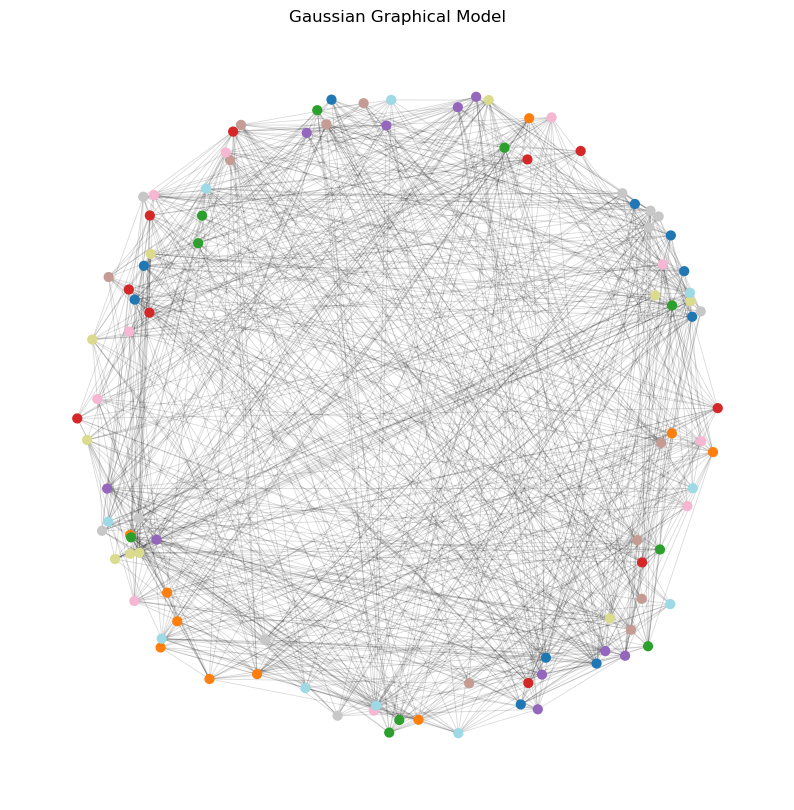

In [47]:
# Build NetworkX graph from your edge list
G = nx.Graph()
G.add_nodes_from(asset_cols)  # ensure isolated nodes also appear
G.add_weighted_edges_from([(u, v, w) for (u, v, w) in edges])

print("G nodes:", G.number_of_nodes(), "G edges:", G.number_of_edges())

# Build sector -> id mapping (with safe fallback)
sectors = sorted(set(asset_to_sector.values()))
sec_to_id = {s: i for i, s in enumerate(sectors)}
unknown_id = len(sectors)  # last color for "Unknown"

node_colors = []
for a in G.nodes():
    s = asset_to_sector.get(a, None)
    node_colors.append(sec_to_id.get(s, unknown_id))

# Layout (k controls spacing)
pos = nx.spring_layout(G, seed=2030, k=0.25)

plt.figure(figsize=(10, 10))

# Use a colormap that can handle many categories
cmap = plt.cm.tab20 if len(sectors) <= 20 else plt.cm.gist_ncar

nx.draw_networkx_nodes(
    G, pos,
    node_size=40,
    node_color=node_colors,
    cmap=cmap
)

nx.draw_networkx_edges(G, pos, alpha=0.15, width=0.6)

plt.title("Gaussian Graphical Model")
plt.axis("off")
plt.show()

The network forms a **single connected component**, indicating that all assets are conditionally connected through **direct** or **indirect** paths, despite the sparsity of direct links. 

### Heatmap of the estimated Precision Matrix

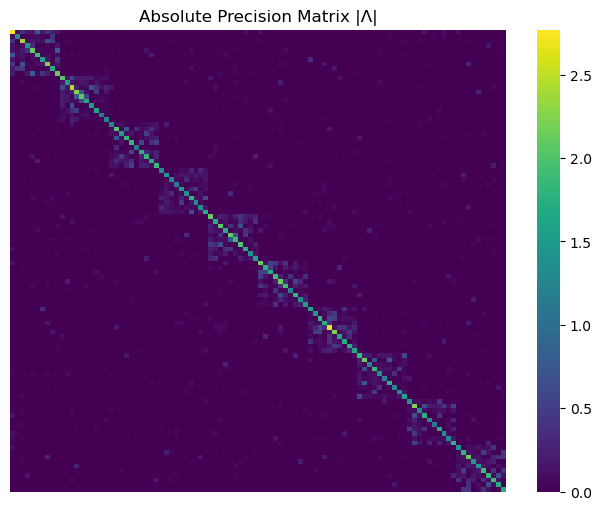

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    np.abs(Lambda_hat),
    cmap="viridis",
    cbar=True,
    xticklabels=False,
    yticklabels=False
)
plt.title("Absolute Precision Matrix |Λ|")
plt.show()

The heatmap shows a **very sparse off-diagonal structure**, with the **majority of entries close to zero**, confirming that most asset pairs are **conditionally independent**, consistent with the **high sparsity leve** induced by the Graphical Lasso.

**Strong dependencies** appear mainly **within sectoral blocks** along the diagonal, while a **small number of off-diagonal links** capture **economically meaningful cross-sector interactions**.

### Edges by sector

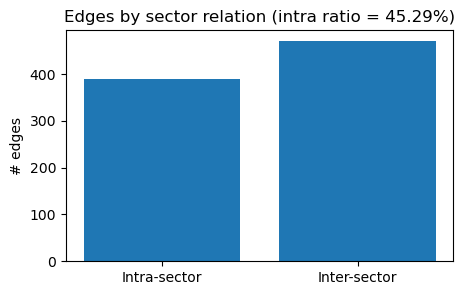

In [53]:
intra, inter, unk, intra_ratio = intra_inter_sector_counts(edges, asset_to_sector)
plt.figure(figsize=(5,3))
plt.bar(["Intra-sector", "Inter-sector"], [intra, inter])
plt.title(f"Edges by sector relation (intra ratio = {intra_ratio:.2%})")
plt.ylabel("# edges")
plt.show()

Among the estimated edges, **388 connect assets** within the **same sector**, corresponding to an **intra-sector ratio** of approximately *45\%**. This indicates the presence of **sectoral clustering**, while the predominance of **inter-sector edges** highlights substantial **cross-sector conditional interactions**.

### Distribution of precision off-diagonal entries (edges)

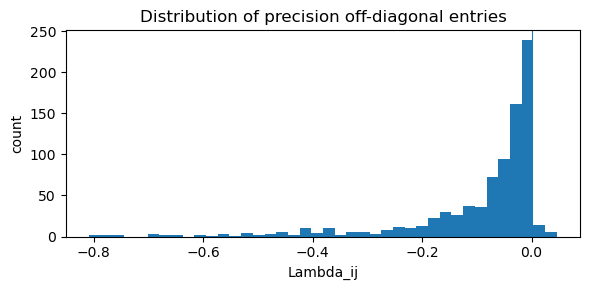

In [56]:
ws = pd.Series([w for _,_,w in edges])
plt.figure(figsize=(6,3))
plt.hist(ws.values, bins=40)
plt.title("Distribution of precision off-diagonal entries")
plt.xlabel("Lambda_ij")
plt.ylabel("count")
plt.axvline(0, lw=0.8)
plt.tight_layout()
plt.show()

This histogram shows that **most coefficients** are concentrated **near zero**, indicating that the **majority of asset pairs** are only **weakly conditionally dependent** once the rest of the system is controlled for. Only a **limited number of edges** exhibit **large magnitudes**, highlighting a **sparse network** driven by a **few strong direct interactions**.

### Top 20 strongest conditional dependencies 

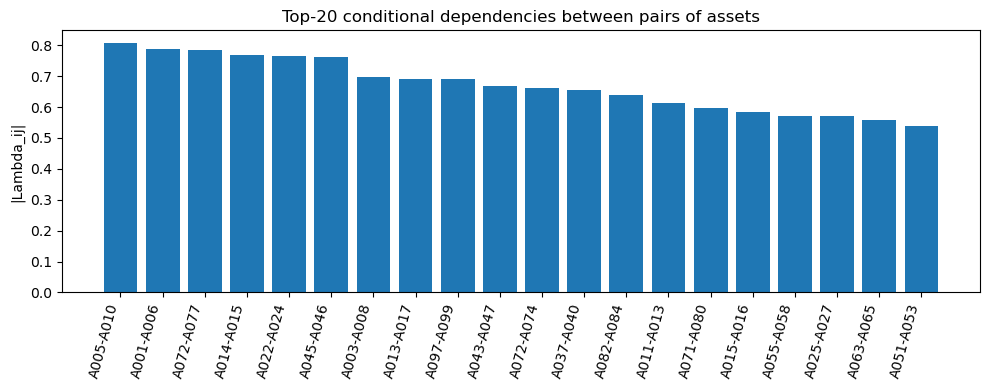

In [59]:
K = 20
df_edges = pd.DataFrame(edges, columns=["u","v","w"])
df_edges["abs_w"] = df_edges["w"].abs()
top = df_edges.sort_values("abs_w", ascending=False).head(K)

plt.figure(figsize=(10,4))
plt.bar(range(len(top)), top["abs_w"].values)
plt.xticks(range(len(top)), [f"{a}-{b}" for a,b in zip(top["u"], top["v"])], rotation=75, ha="right")
plt.ylabel("|Lambda_ij|")
plt.title(f"Top-{K} conditional dependencies between pairs of assets")
plt.tight_layout()
plt.show()

Each bar corresponds to a **pair of assets** whose returns remain **strongly conditionally dependent** after controlling for all other assets in the system. These edges represent the **most relevant direct interactions** in the network and identify the **main channels** through which **shocks can propagate**. 

## 3. Model validation

In [62]:
# Out-of-sample Gaussian log-likelihood 
def test_loglik_up_to_const(Lambda_hat: np.ndarray, X_test: np.ndarray) -> float:
    T_test = X_test.shape[0]
    S_test = (X_test.T @ X_test) / T_test
    sign, logdet = np.linalg.slogdet(Lambda_hat)
    return float(logdet - np.trace(S_test @ Lambda_hat))

# BIC-selected sparse model
ll_bic = test_loglik_up_to_const(Lambda_hat, X_test)

# Dense baseline (no sparsity)
S_train = np.cov(X_train, rowvar=False)
Lambda_full = np.linalg.inv(S_train)
ll_full = test_loglik_up_to_const(Lambda_full, X_test)

alphas = res["alphas_grid"]  

# OOS over alpha grid (robustness, not for selection)
ll_curve = []
for a in alphas:
    _, L = graphical_lasso(emp_cov=S_train, alpha=float(a), max_iter=5000, tol=1e-3)
    ll_curve.append(test_loglik_up_to_const(L, X_test))

ll_curve = np.array(ll_curve)
best_idx = np.argmax(ll_curve)

print("ll_test_sparse =", ll_bic)
print("ll_test_dense      =", ll_full)
print("gap (sparse-dense) =", ll_bic - ll_full)
print("alpha_OOS_best =", float(alphas[best_idx]))
print("ll_test_OSS_best   =", float(ll_curve[best_idx]))
print("gap (OSS-BIC)  =", float(ll_curve[best_idx] - ll_bic))

ll_test_sparse = -55.049097241458284
ll_test_dense      = -62.50481042635797
gap (sparse-dense) = 7.455713184899686
alpha_OOS_best = 0.040470899507597614
ll_test_OSS_best   = -54.780523518503216
gap (OSS-BIC)  = 0.2685737229550682


The BIC-selected sparse model achieves an out-of-sample log-likelihood of **−55.05**, substantially outperforming the dense baseline (**−62.50**), with an improvement of about **7.46** log-likelihood units. This indicates that **regularization** clearly **improves generalization**.

Although the maximum out-of-sample likelihood is obtained at a slightly smaller regularization parameter (**α_OOS = 0.0405**, **ll = −54.78**), the difference with the BIC solution is very small (**gap ≈ 0.27**). Given that our objective is **not prediction** but **structure learning**, we retain the BIC-selected model.

## 4. Inference

In [65]:
@dataclass
class ConditionalGaussian:
    mean: np.ndarray               # conditional mean vector
    cov: np.ndarray                # conditional covariance matrix
    A_names: list                  # names of observed variables
    B_names: list                  # names of inferred variables

# Gaussian conditioning from covariance matrix.
def conditional_gaussian_from_cov(Sigma, names, A, B, a_values):
    idx = {n: i for i, n in enumerate(names)}    # map variable names to indices
    A_idx = [idx[n] for n in A]                  # indices of observed variables
    B_idx = [idx[n] for n in B]                  # indices of unobserved variables

    # Extract covariance submatrices
    Sigma_AA = Sigma[np.ix_(A_idx, A_idx)]
    Sigma_BA = Sigma[np.ix_(B_idx, A_idx)]
    Sigma_AB = Sigma[np.ix_(A_idx, B_idx)]
    Sigma_BB = Sigma[np.ix_(B_idx, B_idx)]

    # Compute conditional mean: Sigma_BA Sigma_AA^{-1} a
    sol_a = np.linalg.solve(Sigma_AA, a_values.reshape(-1, 1))  # solve Sigma_AA x = a
    mean = (Sigma_BA @ sol_a).reshape(-1)

    # Compute conditional covariance (Schur complement)
    cov = Sigma_BB - Sigma_BA @ np.linalg.solve(Sigma_AA, Sigma_AB)

    return ConditionalGaussian(mean=mean, cov=cov, A_names=A, B_names=B)

In [66]:
# Creates conditional mean/variance table.
def inference_table(Sigma, names, A, B, a_vals):
    cg = conditional_gaussian_from_cov(Sigma, names, A, B, a_vals)

    df = pd.DataFrame({
        "Asset": cg.B_names,
        "E[X | A=a]": cg.mean,
        "Var[X | A=a]": np.diag(cg.cov)
    })
    return df

# Compares unconditional and conditional variances to quantify variance reduction.
def compare_unconditional_conditional(Sigma, names, A, B, a_vals):
    idx = {n: i for i, n in enumerate(names)}
    B_idx = [idx[n] for n in B]

    # Unconditional variances
    var_uncond = np.diag(Sigma)[B_idx]

    # Conditional variances
    cg = conditional_gaussian_from_cov(Sigma, names, A, B, a_vals)
    var_cond = np.diag(cg.cov)

    var_reduction = 100 * (var_uncond - var_cond) / var_uncond

    df = pd.DataFrame({
        "Asset": B,
        "Var_uncond": var_uncond,
        "Var_cond": var_cond,
        "Var_reduction_%": var_reduction
    })
    return df
    
# Runs Gaussian inference and summarizes results in tables.
def run_inference(Sigma_hat, asset_cols, A, B, a_vals):
    assert len(A) == len(a_vals), "A and a_vals must have same length"
    
    # Main inference table (mean/var)
    df = inference_table(Sigma_hat, asset_cols, A, B, a_vals)

    # Variance reduction table
    df_var = compare_unconditional_conditional(Sigma_hat, asset_cols, A, B, a_vals)

    # Evidence table (what we condition on)
    evidence = pd.DataFrame({"A (observed)": A, "a_value": a_vals})

    return evidence, df, df_var

Sigma_hat  = res["Sigma"]         
asset_cols = res["asset_cols"]

A = ["A001", "A010", "A050"]
a_vals = np.array([0.5, -0.2, 0.1])
B = ["A002", "A003"]
evidence, df, df_var = run_inference(Sigma_hat, asset_cols, A, B, a_vals)

display(evidence)
display(df)
display(df_var)

,A (observed),a_value
0,A001,0.5
1,A010,-0.2
2,A050,0.1


,Asset,E[X | A=a],Var[X | A=a]
0,A002,0.129389,0.853931
1,A003,0.227139,0.558172


,Asset,Var_uncond,Var_cond,Var_reduction_%
0,A002,1.001431,0.853931,14.728857
1,A003,1.001431,0.558172,44.262526


The **posterior mean** of both assets is positive, with a **stronger response** for **A003**. Moreover, the **conditional variance** of **A003** is reduced by more than **44%** relative to its **unconditional variance**, indicating that a large fraction of its risk is explained by the observed assets. In contrast, **A002** exhibits only a modest **variance reduction** of about **15%**, suggesting a more **idiosyncratic behavior**. 

### Conditional expected returns given a shock of asset A001

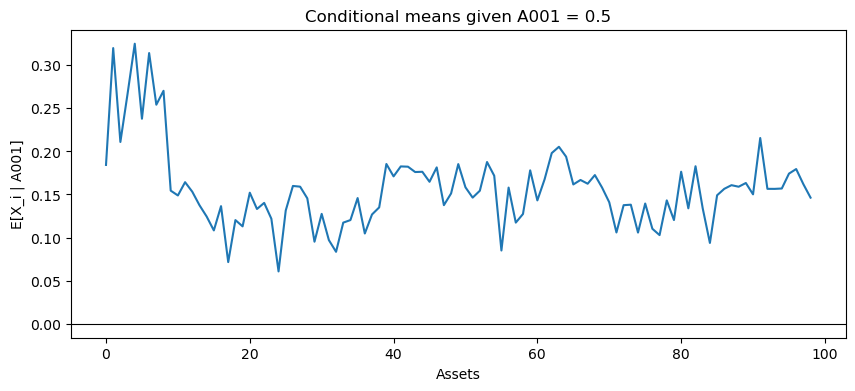

In [69]:
A = ["A001"]
B = [a for a in asset_cols if a not in A]
a_vals = np.array([0.5])

cond_all = conditional_gaussian_from_cov(
    Sigma_hat, asset_cols, A, B, a_vals
)

df_inf = pd.DataFrame({
    "Asset": B,
    "E[X | A001=0.5]": cond_all.mean,
    "Var[X | A001=0.5]": np.diag(cond_all.cov),
    "Sector": [asset_to_sector[a] for a in B]
})
plt.figure(figsize=(10, 4))
plt.plot(df_inf["E[X | A001=0.5]"].values)
plt.axhline(0, color="black", lw=0.8)
plt.title("Conditional means given A001 = 0.5")
plt.ylabel("E[X_i | A001]")
plt.xlabel("Assets")
plt.show()

The response is **heterogeneous** across assets, with the **largest conditional means** observed for **assets** that are **more strongly connected to A001** in the estimated precision matrix.  This pattern illustrates how **shocks propagate** through the MRF via **conditional dependence links** rather than through a hierarchical or directional structure.

### Sector level conditional responses to shock of asset A001

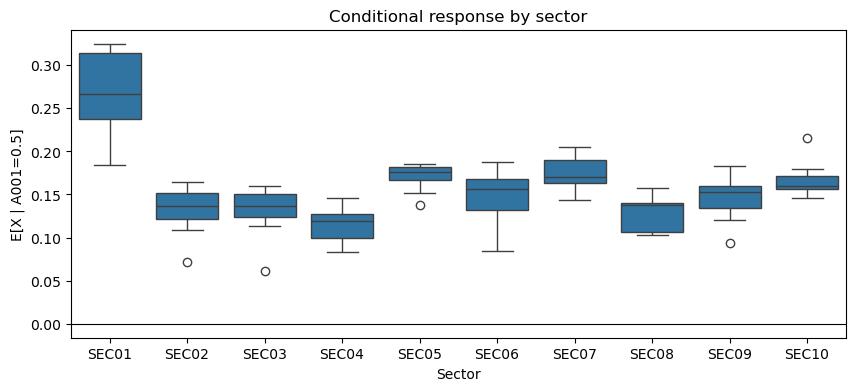

In [72]:
plt.figure(figsize=(10, 4))
sns.boxplot(
    x="Sector",
    y="E[X | A001=0.5]",
    data=df_inf
)
plt.axhline(0, color="black", lw=0.8)
plt.title("Conditional response by sector")
plt.show()

The **sector to which A001 belongs** (SEC01) exhibits the **strongest** and **most concentrated response**, indicating **strong intra-sector spillover effects**. **Other sectors** display **weaker** but **positive conditional responses**, reflecting **cross-sector transmission of shocks** through the network.

# PART III: DISCUSSION

In [75]:
import re
import zipfile
from io import BytesIO, StringIO

import numpy as np
import pandas as pd

from numpy.linalg import slogdet
from sklearn.covariance import graphical_lasso

from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt

import warnings
from sklearn.exceptions import ConvergenceWarning

# 1. Introduction

## Data

In [78]:
# Load Ken French 30 Industry Portfolios (CSV ZIP)
def load_kf_30_industry_portfolios_monthly() -> pd.DataFrame:
    import requests

    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/30_Industry_Portfolios_CSV.zip"
    r = requests.get(url, timeout=60)
    r.raise_for_status()

    z = zipfile.ZipFile(BytesIO(r.content))
    csv_name = [n for n in z.namelist() if n.lower().endswith(".csv")][0]
    raw_text = z.read(csv_name).decode("latin-1", errors="replace")
    lines = raw_text.splitlines()

    # Find first data block starting with YYYYMM,
    # then read until the first non-date row
    start = None
    for i, line in enumerate(lines):
        if re.match(r"^\s*\d{6}\s*,", line):
            start = i
            break
    if start is None:
        raise RuntimeError("Could not locate the start of the returns table in the Ken French CSV.")

    end = start
    for j in range(start, len(lines)):
        if not re.match(r"^\s*\d{6}\s*,", lines[j]):
            end = j
            break

    table_text = "\n".join(lines[start:end])
    df = pd.read_csv(StringIO(table_text), header=None)

    # First column is YYYYMM, others are portfolios
    yyyymm = df.iloc[:, 0].astype(str).str.strip()
    rets = df.iloc[:, 1:].copy()

    # Try to recover column names from a header line above the block
    header_line = None
    for k in range(start - 1, max(-1, start - 80), -1):
        line = lines[k].strip()
        if line and line.count(",") >= 10 and (not re.match(r"^\d{6}\s*,", line)):
            header_line = line
            break

    if header_line is not None:
        colnames = [c.strip() for c in header_line.split(",") if c.strip() != ""]
        if len(colnames) >= rets.shape[1]:
            colnames = colnames[-rets.shape[1]:]
        else:
            colnames = [f"IND{str(i+1).zfill(2)}" for i in range(rets.shape[1])]
    else:
        colnames = [f"IND{str(i+1).zfill(2)}" for i in range(rets.shape[1])]

    rets.columns = colnames

    # Convert to numeric, set missing codes to NaN
    rets = rets.apply(pd.to_numeric, errors="coerce")
    rets = rets.replace([-99.99, -999, -999.99], np.nan)

    # Convert percent to decimal
    rets = rets / 100.0

    # Build month-end datetime index
    idx = pd.to_datetime(yyyymm + "01", format="%Y%m%d") + pd.offsets.MonthEnd(0)
    rets.index = idx
    rets.index.name = "Date"

    return rets

rets = load_kf_30_industry_portfolios_monthly()
rets.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.0053,-0.0519,0.0129,0.0293,0.1097,-0.0049,0.0808,0.0185,0.0816,0.0050,...,0.0083,0.0932,0.0202,0.0770,0.0192,-0.2379,0.0008,0.0188,-0.0002,0.0520
1926-08-31,0.0262,0.2703,0.0652,0.0055,0.1001,-0.0358,-0.0250,0.0417,0.0547,0.0783,...,0.0217,0.0202,0.0443,-0.0237,0.0485,0.0539,-0.0076,-0.0013,0.0426,0.0676
1926-09-30,0.0116,0.0402,0.0126,0.0664,-0.0097,0.0072,-0.0050,0.0069,0.0542,0.0230,...,0.0242,0.0227,0.0018,-0.0554,0.0008,-0.0787,0.0025,-0.0056,-0.0163,-0.0358
1926-10-31,-0.0305,-0.0331,0.0107,-0.0476,0.0947,-0.0466,0.0012,-0.0057,-0.0475,0.0099,...,-0.0011,-0.0198,-0.0109,-0.0508,-0.0263,-0.1538,-0.0219,-0.0411,-0.0552,-0.0847
1926-11-30,0.0636,0.0729,0.0456,0.0166,-0.0587,-0.0053,0.0187,0.0543,0.0518,0.0319,...,0.0163,0.0377,0.0364,0.0385,0.0161,0.0467,0.0654,0.0433,0.0254,0.0416


In [79]:
# Split the time series into training 70% and test 30% 
X = rets.values
X_train_std, X_test_std, mu, sd = standardize_train_test(X, train_ratio=0.7)

## 1. Structure and parameter learning

In [81]:
# BIC-based selection of graphical lasso alpha.
def choose_alpha_bic_glasso_safe(X_train_std, alphas, max_iter=5000, tol=1e-4, eps_nnz=1e-8):
    n, p = X_train_std.shape
    S = np.cov(X_train_std, rowvar=False, bias=False)

    best_bic = np.inf
    best_alpha, best_L, best_Sigma = None, None, None
    failed = []

    for a in map(float, alphas):
        try:
            with warnings.catch_warnings(record=True) as w:
                warnings.simplefilter("always", ConvergenceWarning)

                Sigma_hat, Lambda_hat = graphical_lasso(
                    emp_cov=S,
                    alpha=a,
                    max_iter=max_iter,
                    tol=tol,
                )

                if any(issubclass(wi.category, ConvergenceWarning) for wi in w):
                    failed.append(a)
                    continue

            if (not np.all(np.isfinite(Sigma_hat))) or (not np.all(np.isfinite(Lambda_hat))):
                failed.append(a)
                continue

            sign, logdet = slogdet(Lambda_hat)
            if sign <= 0 or (not np.isfinite(logdet)):
                failed.append(a)
                continue

            # Gaussian log-likelihood (up to constant)
            ll = 0.5 * n * (logdet - np.trace(S @ Lambda_hat))

            off = Lambda_hat.copy()
            np.fill_diagonal(off, 0.0)
            nnz_offdiag = np.sum(np.abs(off) > eps_nnz)
            k = p + nnz_offdiag / 2.0  # diag + unique off-diag

            bic = -2.0 * ll + k * np.log(n)
            if not np.isfinite(bic):
                failed.append(a)
                continue

            if bic < best_bic:
                best_bic = bic
                best_alpha, best_L, best_Sigma = a, Lambda_hat, Sigma_hat

        except Exception:
            failed.append(a)
            continue

    return best_alpha, best_L, best_Sigma, best_bic, failed

In [ ]:
if __name__ == "__main__":

    rets = load_kf_30_industry_portfolios_monthly()

    X = rets.values
    names = list(rets.columns)

    X_train, X_test, mu, sd = standardize_train_test(X, train_ratio=0.7)

    # alpha grid
    alphas = np.logspace(-3, -1, 40)

    alpha_star, Lambda_hat, Sigma_hat, bic_star, failed = choose_alpha_bic_glasso_safe(
        X_train, alphas, max_iter=1000, tol=1e-4
    )

    edges = build_edge_list_from_precision(Lambda_hat, names, thr=1e-6)

    p = Lambda_hat.shape[0]
    T_total = X.shape[0]
    T_train = X_train.shape[0]

    max_edges = p * (p - 1) // 2
    density = len(edges) / max_edges

    print(f"p (industries)       = {p}")
    print(f"T_total (months)     = {T_total}")
    print(f"T_train              = {T_train}")
    print(f"alpha*               = {float(alpha_star):.6f}")
    print(f"BIC*                 = {float(bic_star):.2f}")
    print(f"num_edges            = {len(edges)}")
    print(f"max_edges            = {max_edges}")
    print(f"edge_density         = {density:.4f}")
    print(f"sparsity_offdiag     = {sparsity_offdiag(Lambda_hat, thr=1e-6):.4f}")

Applied to the **30 Industry Portfolios monthly data (T = 1194)**, the **BIC-selected Graphical Lasso** yields a relatively small regularization parameter **0.013**, resulting in a dense Markov Random Field with **255 edges** out of **435 possible connections**. This reflects strong common factor exposure across industries, leading to pervasive conditional dependencies. The off-diagonal sparsity of the estimated precision matrix equals **0.414**, indicating that more than half of the potential conditional dependencies across industries are retained.

### Gaussian Graphical Model

In [ ]:
# Keep only the strongest edges for visualization (e.g., top 150 by |weight|)
edges_sorted = sorted(edges, key=lambda t: abs(t[2]), reverse=True)
edges_vis = edges_sorted[:150]  # adjust if you want

G = nx.Graph()
G.add_nodes_from(names)
G.add_weighted_edges_from(edges_vis)

pos = nx.spring_layout(G, seed=2030, k=0.35)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=250)
nx.draw_networkx_edges(G, pos, alpha=0.25, width=0.8)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("30 Industry Portfolios | Markov Network ")
plt.axis("off")
plt.show()

The Markov Network reveals a **strongly interconnected structure** across industries, with local clustering among economically related sectors and pervasive cross-sector links reflecting common market-wide factors.

### Heatmap of the estimated Precision Matrix

In [ ]:
Theta = Lambda_hat.copy()
D = np.sqrt(np.diag(Theta))
P = -Theta / np.outer(D, D)      
np.fill_diagonal(P, 1.0)

plt.figure(figsize=(10, 8))
plt.imshow(P, aspect="auto")
plt.colorbar(label="Partial correlation")
plt.xticks(range(len(names)), names, rotation=90, fontsize=8)
plt.yticks(range(len(names)), names, fontsize=8)
plt.title("30 Industry Portfolios | Partial Correlation Heatmap (MRF)")
plt.tight_layout()
plt.show()

The partial correlation heatmap highlights **sparse** and **localized conditional dependencies** among industries after controlling for all others.

### Distribution of precision off-diagonal entries (edges)

In [ ]:
ws = pd.Series([w for _, _, w in edges])

plt.figure(figsize=(6,3))
plt.hist(ws.values, bins=40)
plt.axvline(0, lw=0.8)
plt.title("Distribution of precision off-diagonal entries")
plt.xlabel(r"Lambda_ij")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

The distribution of off-diagonal precision entries is **centered around zero**, with a few large values reflecting strong conditional dependencies.

## 2. Model validation

In [130]:
S_train = np.cov(X_train, rowvar=False)

# Dense
Lambda_dense = np.linalg.inv(S_train + 1e-6 * np.eye(S_train.shape[0]))
ll_test_dense = test_loglik_up_to_const(Lambda_dense, X_test)

# Sparse
ll_test_sparse = test_loglik_up_to_const(Lambda_hat, X_test)

print(f"ll_test_sparse = {ll_test_sparse}")
print(f"ll_test_dense      = {ll_test_dense}")
print(f"gap (sparse-dense) = {ll_test_sparse - ll_test_dense}")

# OOS-best alpha 
best_ll = -np.inf
alpha_OOS_best = None

for a in alphas:
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", ConvergenceWarning)
            Sigma_a, Lambda_a = graphical_lasso(S_train, alpha=float(a), max_iter=5000, tol=1e-4)

            # skip if it raised convergence warning
            if any(issubclass(wi.category, ConvergenceWarning) for wi in w):
                continue

        ll = test_loglik_up_to_const(Lambda_a, X_test)
        if np.isfinite(ll) and ll > best_ll:
            best_ll = ll
            alpha_OOS_best = float(a)

    except Exception:
        continue

ll_test_OOS_best = best_ll

print(f"alpha_OOS_best = {alpha_OOS_best}")
print(f"ll_test_OSS_best   = {ll_test_OOS_best}")
print(f"gap (OSS-BIC)  = {ll_test_OOS_best - ll_test_sparse}")

ll_test_sparse = -9.31558886385578
ll_test_dense      = -12.480934430961554
gap (sparse-dense) = 3.165345567105774
alpha_OOS_best = 0.1
ll_test_OSS_best   = -6.188661010955762
gap (OSS-BIC)  = 3.1269278529000175


The BIC-selected sparse model achieves an out-of-sample log-likelihood of **−9.32**, clearly outperforming the dense baseline (**−12.48**), with an improvement of approximately 3.17 log-likelihood units. This provides strong evidence that **regularization enhances out-of-sample generalization** in this setting.

Although the highest out-of-sample log-likelihood is attained at a stronger regularization level (**α_OOS = 0.10, ll = −6.19**), the improvement relative to the BIC-selected model (**gap ≈ 3.13**) is only used as a robustness check. Since our primary objective is structure learning rather than prediction, we retain the BIC-selected model as the final specification, favoring parsimony and interpretability.

## 3. Inference

In [ ]:
@dataclass
class ConditionalGaussian:
    mean: np.ndarray               # conditional mean vector
    cov: np.ndarray                # conditional covariance matrix
    A_names: list                  # names of observed variables
    B_names: list                  # names of inferred variables



# Performs conditional Gaussian inference and summarizes results in tables.
def run_inference_tables(Sigma, names, A, B, a_vals):
    assert len(A) == len(a_vals), "A and a_vals must have same length"
    idx = {n: i for i, n in enumerate(names)}
    B_idx = [idx[n] for n in B]

    cg = conditional_gaussian_from_cov(Sigma, names, A, B, a_vals)

    # Evidence table
    evidence = pd.DataFrame({"A (observed)": A, "a_value": np.asarray(a_vals)})

    # Mean/Var table
    df_meanvar = pd.DataFrame({
        "Industry": cg.B_names,
        "E[X_B | A=a]": cg.mean,
        "Var[X_B | A=a]": np.diag(cg.cov),
        "Std[X_B | A=a]": np.sqrt(np.clip(np.diag(cg.cov), 0, None))
    })

    # Variance reduction table
    var_uncond = np.diag(Sigma)[B_idx]
    var_cond = np.diag(cg.cov)
    var_reduction = 100 * (var_uncond - var_cond) / var_uncond

    df_var = pd.DataFrame({
        "Industry": B,
        "Var_uncond": var_uncond,
        "Var_cond": var_cond,
        "Var_reduction_%": var_reduction
    })

    return evidence, df_meanvar, df_var

In [ ]:
if __name__ == "__main__":
    rets = load_kf_30_industry_portfolios_monthly()
    X = rets.values
    names = list(rets.columns)

    X_train, X_test, mu, sd = standardize_train_test(X, train_ratio=0.7)
    alphas = np.logspace(-3, -1, 40)
    alpha_star, Lambda_hat, Sigma_hat, bic_star, failed = choose_alpha_bic_glasso_safe(
        X_train, alphas, max_iter=1000, tol=1e-4
    )

    A = ["Food", "Hshld", "Cnstr"]      # observed industries
    B = ["Beer", "Smoke"]              # inferred industries
    a_vals = np.array([0.8, -0.4, 0.2])  # shocks in standardized units

    evidence, df_meanvar, df_var = run_inference_tables(Sigma_hat, names, A, B, a_vals)
    display(evidence)

    df_meanvar_show = df_meanvar.rename(columns={"Industry": "Asset"})
    df_var_show     = df_var.rename(columns={"Industry": "Asset"})

    df_meanvar_show = df_meanvar_show[["Asset", "E[X_B | A=a]", "Var[X_B | A=a]"]]
    df_meanvar_show = df_meanvar_show.rename(columns={
        "E[X_B | A=a]": "E[X | A=a]",
        "Var[X_B | A=a]": "Var[X | A=a]"
    })

    display(df_meanvar_show)

    # variance reduction table
    df_var_show = df_var_show.rename(columns={
        "Var_reduction_%": "Var_reduction_%"
    })
    display(df_var_show)

Conditioning on the **observed industries Food**, **Hshld**, and **Cnstr** leads to **positive conditional mean responses** for both Beer and Smoke. In addition, the **conditional variances** are **reduced by more than 50%**, indicating **strong conditional dependence** and **information transmission** within the estimated Markov network.